# Import Modules

In [167]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple
from collections import defaultdict
from pprint import pprint
import random

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Add project directory to sys.path
# pdir = os.path.abspath(os.path.join(os.getcwd(), '.'))
# sys.path.insert(1, pdir)
# from myutils import *

# Other module imports
import ast, math, swifter, csv, json, itertools as it, portion as P

# Set plot style
# plt.style.use('ggplot')

In [168]:
def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = ['seq', 'rpkg', 'frame_id', 'Timestamp', 'lost', 'excl', 'latency', 'xmit_time', 'arr_time']
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['latency']] = df[['latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1
            df['type_id'] = 'LTE_PHY'

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
            df['type_id'] = '5G_NR_ML1'
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

In [285]:
import numpy as np
import pandas as pd
import datetime as dt
from collections import namedtuple
import ast, swifter

# ************************************************* Sheng-Ru Latest Version (09-25) add try except (10-27) add nr arfcn (11-13) add BSID (11-21) *************************************************

def parse_mi_ho(df, tz=8):

    # df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=tz))
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                try:
                    l.append(((t - ho.end).total_seconds(), target, ho))
                except:
                    pass

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None
    
    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }

    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'? -> ({serv_cell}, {serv_freq})'
            D['Conn_Req'].append(HO(start=t,end=end,trans=trans))
            nr_pci = 'O'
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        try:
                            others += f' Near after RLF of trans: {ho.trans}.'
                        except:
                            others += f' Near after RLF.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | ({nr_pci}, {nr_arfcn})'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
            nr_pci = int(df['nr_physCellId'].iloc[i])
            nr_arfcn = int(df['absoluteFrequencySSB'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> ({nr_pci}, {nr_arfcn})'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

            elif b is not None and end2 is not None:
                
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                try:
                    rlf_freq = int(df['Freq'].iloc[idx])
                except:
                    rlf_freq = 0

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans))
                
            else:
                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                others += ' Result in gNB release.'
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                orig_serv = (nr_pci, nr_arfcn) if nr_pci != 'O' else 'O'
                trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Weird gNB release.'
                    print('Weird for scg failure result in gNb Release.')
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D

# ************************************************* parse into readable dataframe *************************************************

def mi_parse_handover(df, tz=8, radical=True, endfill=False):
    
    def parse_trans(item):
        
        chunk = item.split(' | ')
        
        if len(chunk) == 1:
            s_src = np.nan
            s_tgt = np.nan
            if chunk[0] == '':
                m_src = np.nan
                m_tgt = np.nan
            elif chunk[0][0] == '?':
                m_src = np.nan
                m_tgt = chunk[0].split(' -> ')[1]
            else:
                m_src = chunk[0].split(' -> ')[0]
                m_tgt = chunk[0].split(' -> ')[1]
        else:
            if chunk[1] == 'O':
                s_src = np.nan
                s_tgt = np.nan
            else:
                chunk1 = chunk[1].split(' -> ')
                if len(chunk1) == 1:
                    s_src = chunk1[0]
                    s_tgt = np.nan
                else:
                    s_src = chunk1[0] if chunk1[0] != 'O' else np.nan
                    s_tgt = chunk1[1] if chunk1[1] != 'O' else np.nan
                
            chunk1 = chunk[0].split(' -> ')
            if len(chunk1) == 1:
                m_src = chunk1[0]
                m_tgt = np.nan
            else:
                m_src = chunk1[0]
                m_tgt = chunk1[1]
                
        return m_src, m_tgt, s_src, s_tgt
    
    key_mapping = {
        'Conn_Rel': 'CXNR',
        'Conn_Req': 'CXNS',
        'LTE_HO': 'LTEH',
        'MN_HO': 'MCGH',
        'MN_HO_to_eNB': 'SCGR-II',
        'SN_setup': 'SCGA',
        'SN_Rel': 'SCGR-I',
        'SN_HO': 'SCGM',
        'RLF_II': 'MCGF',
        'RLF_III': 'NASR',
        'SCG_RLF': 'SCGF',
        'Add_SCell': 'SCLA'
    }
    
    D = parse_mi_ho(df, tz)
    
    # rename as acronym
    new_D = {key_mapping.get(key, key): value for key, value in D.items()}
    
    if df.empty:
        selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
        table = pd.DataFrame(columns=['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols])
        print('Empty RRC File!!!')
        return table, new_D
    
    table = pd.DataFrame()
    for key, lst in new_D.items():
        table1 = pd.DataFrame(lst, index=[key]*len(lst)).reset_index(names='type')
        table = pd.concat([table, table1], ignore_index=True)

    # add Cell Identity & eNB ID
    sc_info = df[df['type_id'] == 'LTE_RRC_Serv_Cell_Info'][['Timestamp', 'type_id', 'PCI', 'Cell Identity', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']].reset_index(drop=True).rename(columns={'Timestamp': 'start', 'type_id': 'type'})
    sc_info['eNB_ID'] = sc_info['Cell Identity'] // 256
    # sc_info['Cell_ID'] = sc_info['Cell Identity'] % 256
    sc_info = sc_info[['start', 'type', 'PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']]

    table = pd.concat([table, sc_info], ignore_index=True).sort_values(by='start').reset_index(drop=True)

    is_not_start = True
    selected_cols = ['PCI', 'Cell Identity', 'eNB_ID', 'Band ID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    for i, row in table.iterrows():
        if row['type'] == 'LTE_RRC_Serv_Cell_Info':
            is_not_start = False
            info_to_fill = row[selected_cols].to_list()
            continue
        if is_not_start:
            continue
        table.loc[i, selected_cols] = info_to_fill

    table = table[table['type'] != 'LTE_RRC_Serv_Cell_Info'].reset_index(drop=True)
    
    # parse source & target cells
    for i, row in table.iterrows():
        table.loc[i, ['m_src', 'm_tgt', 's_src', 's_tgt']] = parse_trans(row['trans'])
    
    # distinguish intra/inter-eNB HO
    table1 = table[np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])]
    table = table[~np.in1d(table['type'], ['SCLA', 'SCGA', 'SCGR-I', 'SCGF'])].reset_index(drop=True)
    
    table['next_eNB'] = table['eNB_ID'].shift(-1)
    for i, row in table.iloc[:-1].iterrows():
        if row['eNB_ID'] != row['next_eNB'] and row['type'] not in ['CXNS', 'CXNR']:
            if row['others'] == '':
                table.at[i, 'others'] = 'Inter eNB HO.'
            else:
                table.at[i, 'others'] += ' Inter eNB HO.'
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label SCG Addition near after SCG Failure
    table1 = table[~np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])]
    table = table[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGR-II'])].reset_index(drop=True)
    
    table['prev_cmt'] = table['others'].shift(1)
    for i, row in table.iloc[1:].iterrows():
        if row['type'] == 'SCGA':
            if 'Near after SN_Rel' in row['others'] and 'Caused by scg-failure' in row['prev_cmt']:
                table.at[i, 'others'] += ' Caused by scg-failure.'
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    # combine closed SCG Addition & Release pair (which are not caused by scg-failure or RLF) into SCG Change
    table['next_end'] = table['end'].shift(-1)
    table['next_cmt'] = table['others'].shift(-1)
    table['next_s_tgt'] = table['s_tgt'].shift(-1)
    indices_to_remove = []
    for i, row in table.iloc[:-1].iterrows():
        if row['type'] == 'SCGR-I' and 'Near after SN_Rel' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-I'
            indices_to_remove.append(i+1)
        if row['type'] == 'SCGR-II' and 'Near after MN_HO_to_eNB' in row['next_cmt'] and row['s_src'] != row['next_s_tgt']:
            table.at[i, 'end'] = row['next_end']
            table.at[i, 's_tgt'] = row['next_s_tgt']
            table.at[i, 'type'] = 'SCGC-II'
            indices_to_remove.append(i+1)
    table = table.drop(indices_to_remove)
    
    # with pd.option_context('display.max_rows', None): 
    #     display(table)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # re-classify eNB HO & MeNB HO
    table.loc[np.in1d(table['type'], ['LTEH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'ENBH'
    table.loc[np.in1d(table['type'], ['MCGH']) & table['others'].str.contains('Inter eNB HO'), 'type'] = 'MNBH'
    
    # add the next eNB ID when meeting inter-eNB HO
    table1 = table[~table['others'].str.contains('Inter eNB HO')]
    table = table[table['others'].str.contains('Inter eNB HO')].reset_index(drop=True)
    
    table['next_eNB_ID'] = table['eNB_ID'].shift(-1)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # detect band change and add the next Band ID when meeting inter-Freq HO
    band_mapping = {}
    for i, row in table[~table.duplicated(subset=['DL frequency'])].dropna(subset=['DL frequency']).iterrows():
        band_mapping[int(row['DL frequency'])] = row['Band ID']
    
    print(band_mapping)
    
    table1 = table[~table['others'].str.contains('Inter frequency HO')]
    table = table[table['others'].str.contains('Inter frequency HO')].reset_index(drop=True)
    
    table['next_BID'] = table['Band ID'].shift(-1)
    try:
        table.at[len(table)-1, 'next_BID'] = band_mapping[ast.literal_eval(table.iloc[-1]['m_tgt'])[1]]
    except:
        pass
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # check whether RLF is near after an HO event
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    table['next_start'] = table['start'].shift(-1)
    table['next_type'] = table['type'].shift(-1)
    table['near_before_RLF'] = False
    for i, row in table.iloc[:-1].iterrows():
        # check whether an HO event is near before an RLF (in 3 seconds)
        if row['type'] in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II'] and \
            row['next_type'] in ['NASR', 'MCGF', 'SCGF']:
                if row['end'] > row['next_start'] - pd.Timedelta(seconds=1):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 1 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 1 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=2):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 2 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 2 sec.'
                        
                elif row['end'] > row['next_start'] - pd.Timedelta(seconds=3):
                    table.at[i, 'near_before_RLF'] = True
                    next_type = row['next_type']
                    if row['others'] == '':
                        table.at[i, 'others'] = f'Near before {next_type} 3 sec.'
                    else:
                        table.at[i, 'others'] += f' Near before {next_type} 3 sec.'
                    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # label (PCI, BSID)
    table1 = table[np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])]
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    for col in ['m_src', 's_src']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna()].copy()
        filtered_table1[new_col] = filtered_table1['m_src'].astype(str) + ', ' + filtered_table1['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    for col in ['m_tgt', 's_tgt']:
        new_col = f'{col}1'
        filtered_table = table[table[col].isna()].copy()
        filtered_table[new_col] = np.nan
        
        # add BSID (eNB)
        filtered_table1 = table[table[col].notna() & table['next_eNB_ID'].notna()].copy()
        filtered_table1[new_col] = filtered_table1['m_src'].astype(str) + ', ' + filtered_table1['next_eNB_ID'].astype(str)
        filtered_table2 = table[table[col].notna() & table['next_eNB_ID'].isna()].copy()
        filtered_table2[new_col] = filtered_table2['m_src'].astype(str) + ', ' + filtered_table2['eNB_ID'].astype(str)
        
        table = pd.concat([filtered_table, filtered_table1, filtered_table2], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    table = pd.concat([table, table1], ignore_index=True).sort_values(by='start').reset_index(drop=True)
    
    # add category
    table['category'] = 'Others'
    table.loc[np.in1d(table['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'category'] = 'HO'
    table.loc[np.in1d(table['type'], ['MCGF', 'NASR', 'SCGF']), 'category'] = 'RLF'

    # add failure cause
    failure_cause = [
        'reconfigurationFailure (0)', 'handoverFailure (1)', 'otherFailure (2)',
        't310-Expiry (0)', 'randomAccessProblem (1)', 'rlc-MaxNumRetx (2)', 'synchReconfigFailureSCG (3)', 'scg-ReconfigFailure (4)', 'srb3-IntegrityFailure (5)', 'other-r16 (6)'
    ]
    
    for tag in failure_cause:
        table.loc[table['others'].str.contains(tag, regex=False), 'cause'] = tag
        table['others'] = table['others'].str.replace(f" {tag}.", "", regex=False)
        table['others'] = table['others'].str.replace(f"{tag}.", "", regex=False)
    
    # add Access Technology type
    table['4G_5G'] = '4G'
    table.loc[np.in1d(table['type'], ['SCGM', 'SCGA', 'SCGR-I', 'SCGC-I', 'SCGF']), '4G_5G'] = '5G'
    table.loc[np.in1d(table['type'], ['SCGR-II', 'SCGC-II']), '4G_5G'] = '4G_5G'
    
    # add more boolean columns
    table['inter-eNB'] = False
    table.loc[table['others'].str.contains('Inter eNB HO'), 'inter-eNB'] = True
    table['others'] = table['others'].str.replace(" Inter eNB HO.", "")
    table['others'] = table['others'].str.replace("Inter eNB HO.", "")
    
    table['inter-Freq'] = False
    table.loc[table['others'].str.contains('Inter frequency HO'), 'inter-Freq'] = True
    table['others'] = table['others'].str.replace(" Inter frequency HO.", "")
    table['others'] = table['others'].str.replace("Inter frequency HO.", "")
    
    table['band_cng'] = False
    table.loc[table['inter-Freq'] & (table['Band ID'] != table['next_BID']), 'band_cng'] = True
    
    table['inter-RAT'] = False
    table.loc[np.in1d(table['type'], ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']), 'inter-RAT'] = True
    
    table['inter-gNB'] = False
    table.loc[np.in1d(table['type'], ['SCGC-I', 'SCGC-II']), 'inter-gNB'] = True
    
    # find row na-"end" & fill with "start"
    if endfill:
        nan_end_rows = table[table['end'].isnull()]
        table.loc[nan_end_rows.index, 'end'] = nan_end_rows['start']
    
    # ignore CXNS, CXNR, SCLA
    table = table[~np.in1d(table['type'], ['CXNS', 'CXNR', 'SCLA'])].reset_index(drop=True)
    
    # remove SCG Addition, Release caused by SCG Failure or any other RLFs if needed (default: True)
    if radical:
        table = table[~((table['others'].str.contains('Caused by scg-failure') | table['others'].str.contains('Near after RLF')))].reset_index(drop=True)
    
    # select columns
    selected_cols = ['m_src1', 'm_tgt1', 's_src1', 's_tgt1', 'PCI', 'Cell Identity', 'eNB_ID', 'next_eNB_ID', 'Band ID', 'next_BID', 'DL frequency', 'UL frequency', 'DL bandwidth', 'UL bandwidth', 'TAC', 'MCC', 'MNC']
    table = table[['type', 'start', 'end', 'others', 'm_src', 'm_tgt', 's_src', 's_tgt', 'category', 'inter-eNB', 'inter-gNB', 'inter-Freq', 'band_cng', 'inter-RAT', '4G_5G', 'cause', 'near_before_RLF', *selected_cols]]
    
    return table, new_D

In [286]:
import os
import json

# Specify root directory
root_dir = "/Users/jackbedford/Desktop/MOXA/Code/data"

# Collect dates
dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s != 'backup']
date_dirs = [os.path.join(root_dir, s) for s in dates]

for date, date_dir in zip(dates, date_dirs):
    # Specify the path to your JSON file
    date = os.path.basename(date_dir)
    json_filepath = os.path.join(date_dir, f'{date}.json')
    
    # Read the JSON file and load its contents into a dictionary
    with open(json_filepath, 'r', encoding='utf-8') as json_file:
        my_dict = json.load(json_file)
    
    if not my_dict:
        continue
        
    print(date, len(my_dict))
    
    for expr, item in my_dict.items():
        print({expr: item})

2023-03-16 1
{'UDP_Bandlock_B1_B7_B8_RM500Q': {'route': 'BR', 'devices': {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '19:23', ''], [2, '動物園', '萬芳醫院', '19:32', ''], [3, '萬芳醫院', '動物園', '19:39', ''], [4, '動物園', '萬芳醫院', '19:47', ''], [5, '萬芳醫院', '動物園', '19:55', ''], [6, '動物園', '萬芳醫院', '20:03', ''], [7, '萬芳醫院', '動物園', '20:09', ''], [8, '動物園', '萬芳醫院', '20:18', ''], [9, '萬芳醫院', '動物園', '20:27', ''], [10, '動物園', '萬芳醫院', '20:33', ''], [11, '萬芳醫院', '動物園', '20:42', ''], [12, '動物園', '萬芳醫院', '20:49', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-03-26 1
{'UDP_Bandlock_All_RM500Q': {'route': 'BR', 'devices': {'qc00': 'All', 'qc02': 'All', 'qc03': 'All'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '萬芳醫院', '動物園', '16:36', ''], [2, '動物園', '萬芳醫院', '16:46', ''

# Select Dates, Routes, Experiments (BR)

In [193]:
# Select Dates
sel_dates = [s for s in dates if s >= '2023-09-12']
# sel_dates = [s for s in dates if s < '2023-09-12']
# sel_dates = [s for s in dates if s >= '2023-08-16' and s < '2023-09-12']
# sel_dates = dates[:5]
# sel_dates = dates[-8:]
# sel_dates = ['2023-03-16']
# sel_dates = dates[:]
exc_dates = ['2023-06-12', '2023-06-13']
date_dirs = [os.path.join(root_dir, s) for s in sel_dates if s not in exc_dates]

# Select Experiment Names
# sel_exps = ['UDP_Bandlock_9S_Phone_Brown', 'UDP_Bandlock_9S_Phone_Airport']
sel_exps = []
exc_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
# exc_exps = []

# Select Routes
sel_routes = ['BR']
# sel_routes = []

In [194]:
# Collect Experiments
exps_dict = {}

for date_dir in date_dirs:
    date = os.path.basename(date_dir)
    
    # Specify the path to your JSON file
    json_filepath = os.path.join(date_dir, f'{date}.json')
    
    # Read the JSON file and load its contents into a dictionary
    with open(json_filepath, 'r', encoding='utf-8') as json_file:
        my_dict = json.load(json_file)
    
    if not my_dict:
        continue
    
    for i, (expr, item) in enumerate(my_dict.items()):
        if len(sel_exps) != 0 and expr not in sel_exps:
            continue
        
        if len(exc_exps) != 0 and expr in exc_exps:
            continue
        
        if len(sel_routes) != 0 and item['route'] not in sel_routes:
            continue
        
        try:
            exps_dict[date] = {**exps_dict[date], **{expr: item}}
        except:
            exps_dict[date] = {expr: item}

for date, exps in exps_dict.items():
    # print(date, len(exps), exps)
    print(date, len(exps))
    
    for expr, item in exps.items():
        print({expr: item})

2023-09-12-2 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '13:34', '到木柵才想起要開GPS'], [2, '南港展覽館', '動物園', '14:52', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}
2023-09-21 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '14:29', ''], [2, '南港展覽館', '動物園', 

## Check NR Alive & NR Duration

In [195]:
def seconds_to_minutes_seconds_milliseconds(duration_in_seconds):
    # Convert to a timedelta object
    duration_timedelta = dt.timedelta(seconds=duration_in_seconds)

    # Extract minutes, seconds, and milliseconds
    minutes, seconds = divmod(duration_timedelta.seconds, 60)
    milliseconds = duration_timedelta.microseconds // 1000

    # Format the result
    formatted_time = "{:02}:{:02}.{:03}".format(minutes, seconds, milliseconds)

    return(formatted_time)

for date, exps in exps_dict.items():
    # print(date, len(exps), exps)
    print(date, len(exps))
    
    for ename, expr in exps.items():
        expr_dir = os.path.join(root_dir, date, ename)
        print({ename: expr})
        
        # Check NR Alive & NR Duration
        nr_check_alive_path = os.path.join(expr_dir, 'nr_alive_checktable.csv')
        nr_duration_path = os.path.join(expr_dir, 'nr_duration.csv')
        
        if os.path.isfile(nr_check_alive_path) and os.path.isfile(nr_duration_path):
            alive_table = pd.read_csv(nr_check_alive_path)
            duration_table = pd.read_csv(nr_duration_path)
        else:
            devices = list(expr['devices'].keys())
            trips = ['#{:02d}'.format(s[0]) for s in expr['ods'][1:]]

            alive_table = pd.DataFrame(columns=['Tr.', *devices])
            duration_table = pd.DataFrame(columns=['Tr.', *devices])
            for trip in trips:
                alive_list = [trip] + ['O'] * len(devices)
                duration_list = [trip] + ['-'] * len(devices)
                
                for j, dev in enumerate(devices):
                    data_dir = os.path.join(expr_dir, dev, trip, 'data')
                    rrc_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('rrc.csv')][0]
                    nr_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('nr_ml1.csv')][0]
                    
                    rrc_df = pd.read_csv(rrc_filepath, low_memory=False)
                    flag1 = sum(np.in1d(rrc_df['failureType-r15'], 'rlc-MaxNumRetx (2)')) > 0
                    if flag1:
                        alive_list[j+1] = '∆'
                        
                    nr_df = pd.read_csv(nr_filepath)
                    flag2 = nr_df.empty
                    if flag2:
                        alive_list[j+1] = 'X'
                    else:
                        nr_df['Timestamp'] = pd.to_datetime(nr_df['Timestamp'])
                        total_seconds = (nr_df.iloc[-1]['Timestamp'] - nr_df.iloc[0]['Timestamp']).total_seconds()
                        # print(seconds_to_minutes_seconds_milliseconds(total_seconds))
                        duration_list[j+1] = seconds_to_minutes_seconds_milliseconds(total_seconds)
                        
                alive_table.loc[len(alive_table)] = alive_list
                duration_table.loc[len(duration_table)] = duration_list
            
            alive_table.to_csv(nr_check_alive_path, index=False)
            duration_table.to_csv(nr_duration_path, index=False)
        
        display(alive_table)
        display(duration_table)

print('O: RF Module is always on.')
print('∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!')
print('X: RF Module has never been turned on. It could be under pure LTE or an anomaly.')

2023-09-12-2 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '13:34', '到木柵才想起要開GPS'], [2, '南港展覽館', '動物園', '14:52', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,O,O,O,O,O,O,O,O,X
1,#02,O,O,O,O,O,O,O,O,X


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,44:13.218,42:57.228,38:40.173,26:46.132,23:53.395,26:27.473,25:55.293,19:29.593,-
1,#02,77:32.880,36:22.987,63:13.807,44:44.908,52:43.370,54:47.065,60:55.527,32:19.581,-


2023-09-21 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '動物園', '南港展覽館', '14:29', ''], [2, '南港展覽館', '動物園', '15:09', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,O,O,O,X,O,X,O,O,X
1,#02,X,X,X,X,X,X,X,X,X


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,00:14.321,00:23.441,00:31.702,-,00:06.500,-,00:10.521,00:12.180,-
1,#02,-,-,-,-,-,-,-,-,-


2023-11-09 1
{'UDP_Bandlock_9S_Phone_Brown': {'route': 'BR', 'devices': {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B7', 'sm04': 'B8', 'sm05': 'B3B7', 'sm06': 'B3B8', 'sm07': 'B7B8', 'sm08': 'LTE'}, 'ods': [[0, 'Origin Station', 'Destination Station', 'Departure Time', 'Notes'], [1, '木柵', '南港展覽館', '12:21', ''], [2, '南港展覽館', '動物園', '13:41', '']], 'stations': ['動物園', '木柵', '萬芳社區', '萬芳醫院', '辛亥', '麟光', '六張犁', '科技大樓', '大安', '忠孝復興', '南京復興', '中山國中', '松山機場', '大直', '劍南路', '西湖', '港墘', '文德', '內湖', '大湖公園', '葫洲', '東湖', '南港軟體園區', '南港展覽館'], 'telecom': 'CHT', 'protocol': 'UDP', 'length': [250, 'byte'], 'bitrate': [1, 'Mbps'], 'notes': ''}}


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,∆,∆,∆,∆,∆,∆,∆,O,X
1,#02,∆,∆,O,∆,∆,∆,∆,∆,X


,Tr.,sm00,sm01,sm02,sm03,sm04,sm05,sm06,sm07,sm08
0,#01,48:49.692,23:16.634,24:51.939,48:51.704,48:52.409,25:20.193,48:51.466,48:51.545,-
1,#02,81:15.298,71:03.285,79:24.548,81:22.240,81:31.885,80:21.801,81:13.001,80:44.819,-


O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.


## Test

In [287]:
date = '2023-11-09'; name = 'UDP_Bandlock_9S_Phone_Brown'; dev = 'sm00'; trip = '#01'
data_dir = os.path.join(root_dir, date, name, dev, trip, 'data')
# print(os.path.isdir(data_dir))

rrc_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('rrc.csv')][0]
ho_df, _ = mi_parse_handover(pd.read_csv(rrc_filepath))

{3050: 7.0, 1750: 3.0, 3650: 8.0, 1400: 3.0}


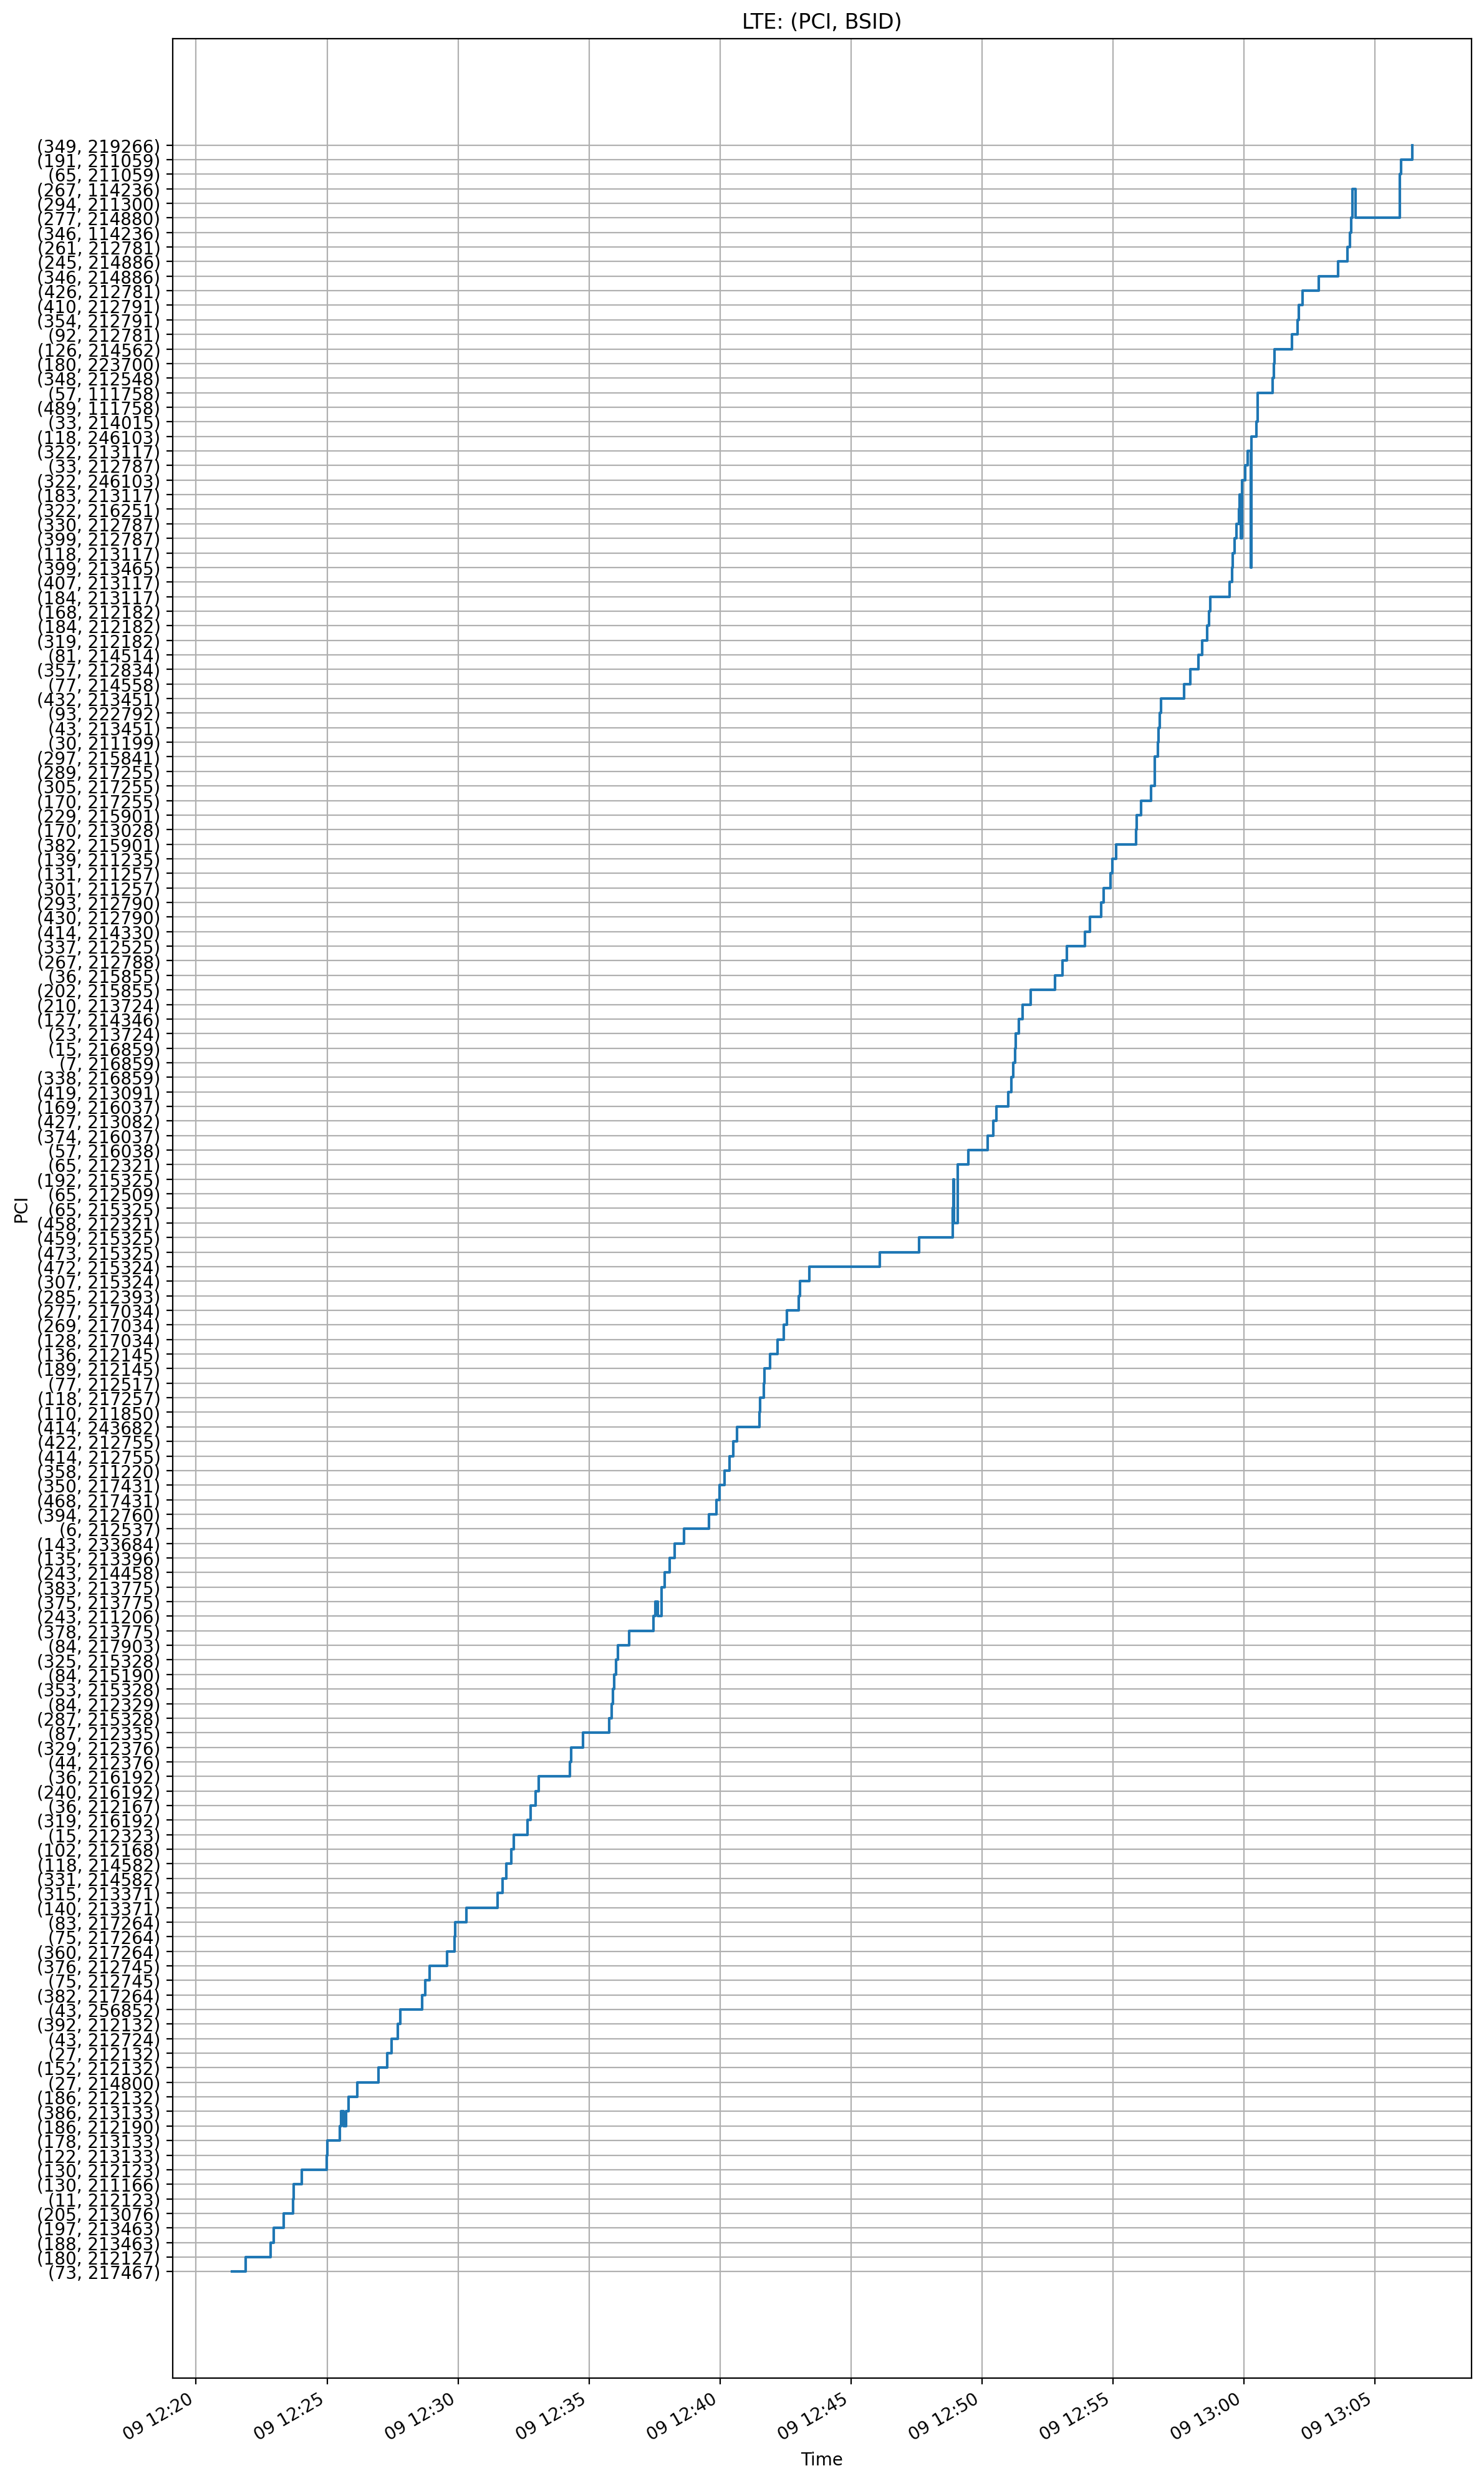

In [282]:
ho_tmp = ho_df[np.in1d(ho_df['type'], ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGR-II', 'SCGC-II', 'MCGH', 'NASR'])].copy().reset_index(drop=True)

# 取資料點
ts = [ho_tmp['start'].iloc[0], *ho_tmp['end'].to_list()]
mpci = [ho_tmp['m_src1'].iloc[0], *ho_tmp['m_tgt1'].to_list()]
mpci = ['(' + s.split(', ')[0][1:] + ', ' + s.split(', ')[2][:-2] + ')' for s in mpci]

# 創建畫布和子圖
fig, ax = plt.subplots(figsize=(12, 20))

# 繪製階梯狀圖
ax.step(ts, mpci, where='post', label='階梯狀圖')

# 添加標籤和標題
ax.set_xlabel('Time')
ax.set_ylabel('PCI')
ax.set_title('LTE: (PCI, BSID)')

# 網格
ax.grid(True)

# 顯示圖形
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

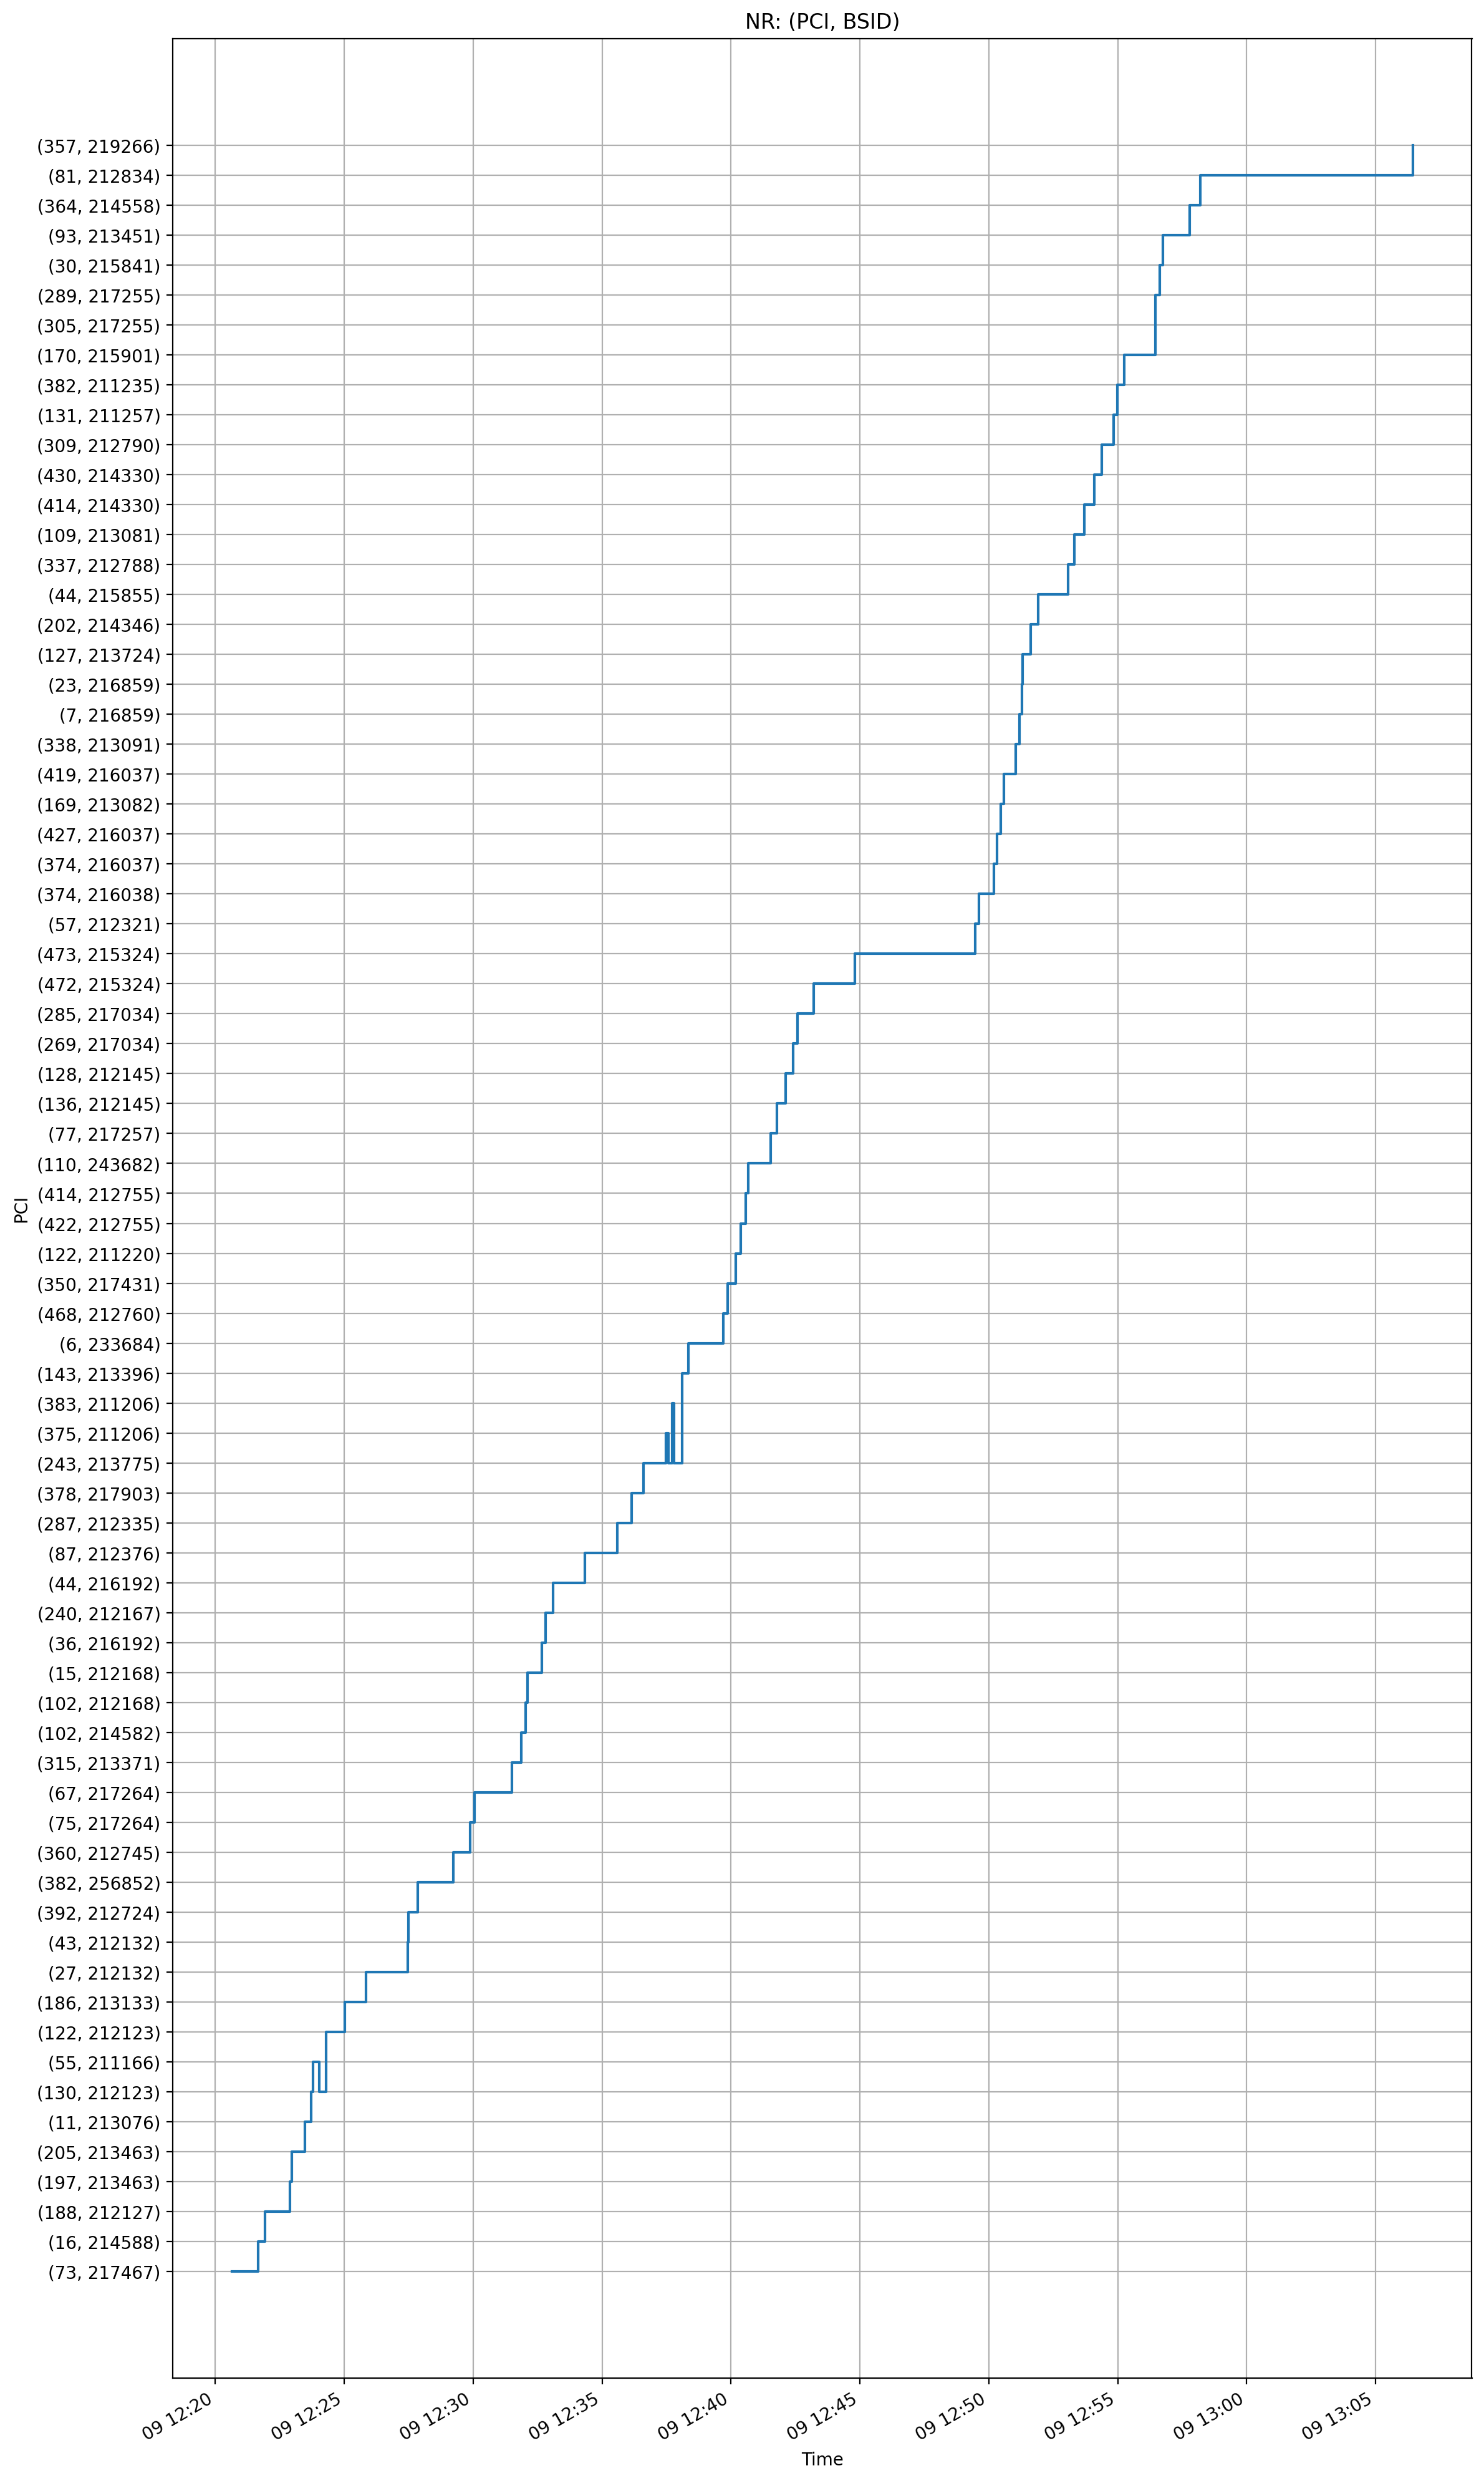

In [283]:
ho_tmp = ho_df[np.in1d(ho_df['type'], ['SCGM', 'SCGA', 'SCGC-I', 'SCGC-II'])].copy().reset_index(drop=True)

# 取資料點
ts = ho_tmp['end'].to_list()
spci = ho_tmp['s_tgt1'].to_list()
spci = ['(' + s.split(', ')[0][1:] + ', ' + s.split(', ')[2][:-2] + ')' for s in spci]

# 創建畫布和子圖
fig, ax = plt.subplots(figsize=(12, 20))

# 繪製階梯狀圖
ax.step(ts, spci, where='post', label='階梯狀圖')

# 添加標籤和標題
ax.set_xlabel('Time')
ax.set_ylabel('PCI')
ax.set_title('NR: (PCI, BSID)')

# 網格
ax.grid(True)

# 顯示圖形
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [288]:
ho_df

,type,start,end,others,m_src,m_tgt,s_src,s_tgt,category,inter-eNB,inter-gNB,inter-Freq,band_cng,inter-RAT,4G_5G,cause,near_before_RLF,m_src1,m_tgt1,s_src1,s_tgt1,PCI,Cell Identity,eNB_ID,next_eNB_ID,Band ID,next_BID,DL frequency,UL frequency,DL bandwidth,UL bandwidth,TAC,MCC,MNC
0,SCGA,2023-11-09 12:20:38.242029,2023-11-09 12:20:38.261991,Set up 1 SCell.,"(73, 3050)",NaN,NaN,"(73, 630912)",HO,False,False,False,False,True,5G,NaN,False,"(73, 3050), 217467.0",NaN,NaN,"(73, 3050), 217467.0",73.0,55671576.0,217467.0,NaN,7.0,NaN,3050.0,21050.0,20 MHz,20 MHz,11200.0,466.0,92.0
1,MCGH,2023-11-09 12:21:21.633986,2023-11-09 12:21:21.673772,Set up 1 SCell.,"(73, 3050)","(73, 1750)","(73, 630912)",NaN,HO,False,False,True,True,False,4G,NaN,False,"(73, 3050), 217467.0","(73, 3050), 217467.0","(73, 3050), 217467.0",NaN,73.0,55671576.0,217467.0,NaN,7.0,3.0,3050.0,21050.0,20 MHz,20 MHz,11200.0,466.0,92.0
2,SCGM,2023-11-09 12:21:30.755127,2023-11-09 12:21:30.773059,,"(73, 1750)",NaN,"(73, 630912)","(180, 630912)",HO,False,False,False,False,False,5G,NaN,False,"(73, 1750), 217467.0",NaN,"(73, 1750), 217467.0","(73, 1750), 217467.0",73.0,55671575.0,217467.0,NaN,3.0,NaN,1750.0,19750.0,20 MHz,20 MHz,11200.0,466.0,92.0
3,MCGF,2023-11-09 12:21:35.865490,2023-11-09 12:21:35.944595,,"(73, 1750)","(16, 1750)","(180, 630912)",NaN,RLF,True,False,False,False,False,4G,otherFailure (2),False,"(73, 1750), 217467.0","(73, 1750), 214588.0","(73, 1750), 217467.0",NaN,73.0,55671575.0,217467.0,214588.0,3.0,NaN,1750.0,19750.0,20 MHz,20 MHz,11200.0,466.0,92.0
4,SCGM,2023-11-09 12:21:39.996955,2023-11-09 12:21:40.015080,Near before MCGF 2 sec.,"(16, 1750)",NaN,"(16, 630912)","(180, 630912)",HO,False,False,False,False,False,5G,NaN,True,"(16, 1750), 214588.0",NaN,"(16, 1750), 214588.0","(16, 1750), 214588.0",16.0,54934551.0,214588.0,NaN,3.0,NaN,1750.0,19750.0,20 MHz,20 MHz,11200.0,466.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,MCGF,2023-11-09 13:05:42.080370,2023-11-09 13:05:42.159374,,"(294, 1750)","(65, 1750)",NaN,NaN,RLF,True,False,False,False,False,4G,otherFailure (2),False,"(294, 1750), 214880.0","(294, 1750), 219263.0",NaN,NaN,294.0,55009293.0,214880.0,219263.0,3.0,NaN,1750.0,19750.0,20 MHz,20 MHz,11800.0,466.0,92.0
282,ENBH,2023-11-09 13:05:57.195820,2023-11-09 13:05:57.219633,Set up 3 SCell.,"(65, 1750)","(191, 1750)",NaN,NaN,HO,True,False,False,False,False,4G,NaN,False,"(65, 1750), 219263.0","(65, 1750), 211059.0",NaN,NaN,65.0,56131361.0,219263.0,211059.0,3.0,NaN,1750.0,19750.0,20 MHz,20 MHz,11800.0,466.0,92.0
283,ENBH,2023-11-09 13:05:59.487632,2023-11-09 13:05:59.513945,Set up 3 SCell.,"(191, 1750)","(349, 1750)",NaN,NaN,HO,True,False,False,False,False,4G,NaN,False,"(191, 1750), 211059.0","(191, 1750), 211059.0",NaN,NaN,191.0,54031117.0,211059.0,NaN,3.0,NaN,1750.0,19750.0,20 MHz,20 MHz,11800.0,466.0,92.0
284,LTEH,2023-11-09 13:06:26.038185,2023-11-09 13:06:26.056818,Set up 3 SCell.,"(349, 1750)","(357, 1750)",NaN,NaN,HO,False,False,False,False,False,4G,NaN,False,"(349, 1750), 219266.0","(349, 1750), 219266.0",NaN,NaN,349.0,56132129.0,219266.0,NaN,3.0,NaN,1750.0,19750.0,20 MHz,20 MHz,11800.0,466.0,92.0


# Visualization

## Single Radio Trace Visualize

In [185]:
date = '2023-08-16'; name = 'UDP_Phone_LTE_NR'; dev = 'sm01'; trip = '#01'
data_dir = os.path.join(root_dir, date, name, dev, trip, 'data')
# print(os.path.isdir(data_dir))

rrc_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('rrc.csv')][0]
lte_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and not s.endswith('nr_ml1.csv') and s.endswith('ml1.csv')][0]
nr_filepath = [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('nr_ml1.csv')][0]
dl_filepath = os.path.join(data_dir, 'udp_dnlk_loss_latency.csv')
ul_filepath = os.path.join(data_dir, 'udp_uplk_loss_latency.csv')

print(rrc_filepath, os.path.isfile(rrc_filepath))
print(lte_filepath, os.path.isfile(lte_filepath))
print(nr_filepath, os.path.isfile(nr_filepath))
print(dl_filepath, os.path.isfile(dl_filepath))
print(ul_filepath, os.path.isfile(ul_filepath))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-08-16/UDP_Phone_LTE_NR/sm01/#01/data/diag_log_sm01_2023-08-16_15-03-19_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-08-16/UDP_Phone_LTE_NR/sm01/#01/data/diag_log_sm01_2023-08-16_15-03-19_ml1.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-08-16/UDP_Phone_LTE_NR/sm01/#01/data/diag_log_sm01_2023-08-16_15-03-19_nr_ml1.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-08-16/UDP_Phone_LTE_NR/sm01/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-08-16/UDP_Phone_LTE_NR/sm01/#01/data/udp_uplk_loss_latency.csv True


In [186]:
def single_radio_visualize(dl_df, ul_df, ho_df, start_time='', stop_time=''):
    
    data_date = dl_df['Timestamp'].iloc[0].strftime('%Y-%m-%d')

    if start_time:
        start_timestamp = pd.to_datetime(f'{data_date} {start_time}')
        print(start_timestamp)
        dl_df = dl_df[dl_df['arr_time'] > start_timestamp]
        ul_df = ul_df[ul_df['xmit_time'] > start_timestamp]
        ho_df = ho_df[ho_df['start'] > start_timestamp]
    if stop_time:
        stop_timestamp = pd.to_datetime(f'{data_date} {stop_time}')
        print(stop_timestamp)
        dl_df = dl_df[dl_df['arr_time'] < stop_timestamp]
        ul_df = ul_df[ul_df['xmit_time'] < stop_timestamp]
        ho_df = ho_df[ho_df['end'] < stop_timestamp]

    dl_lost_df = dl_df[dl_df['lost']]
    dl_lost_ts = dl_lost_df['arr_time'].tolist()
    dl_excl_df = dl_df[~dl_df['lost'] & dl_df['excl']]
    dl_excl_ts = dl_excl_df['arr_time'].tolist()

    ul_lost_df = ul_df[ul_df['lost']]
    ul_lost_ts = ul_lost_df['xmit_time'].tolist()
    ul_excl_df = ul_df[~ul_df['lost'] & ul_df['excl']]
    ul_excl_ts = ul_excl_df['xmit_time'].tolist()

    print('Downlink:', 'PLR', round(dl_df['lost'].mean(), 3), '%', 'ELR', round((~dl_df['lost'] & dl_df['excl']).mean(), 3), '%')
    print('Uplink:  ', 'PLR', round(ul_df['lost'].mean(), 3), '%', 'ELR', round((~ul_df['lost'] & ul_df['excl']).mean(), 3), '%')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plotting the points
    ax.scatter(dl_lost_ts, [8] * len(dl_lost_ts), marker='o', color='red', alpha=0.85, s=30)
    ax.scatter(dl_excl_ts, [7] * len(dl_excl_ts), marker='o', color='blue', alpha=0.85, s=30)
    ax.scatter(ul_lost_ts, [6] * len(ul_lost_ts), marker='x', color='red', alpha=0.85, s=30)
    ax.scatter(ul_excl_ts, [5] * len(ul_excl_ts), marker='x', color='blue', alpha=0.85, s=30)

    # Handover-related events
    intra_rat_4g = ['LTEH', 'MCGH', 'ENBH', 'MNBH']
    intra_rat_5g = ['SCGM']
    inter_rat = ['SCGA', 'SCGR-I', 'SCGC-I', 'SCGR-II', 'SCGC-II']
    rlf = ['MCGF', 'NASR', 'SCGF']

    random_seed = 2024
    random.seed(random_seed)
    shapes = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    sel_shapes = random.sample(shapes, len([*intra_rat_4g, *intra_rat_5g, *inter_rat, *rlf]))

    i = 0 
    for tags, yval in zip([intra_rat_4g, intra_rat_5g, inter_rat, rlf], [4, 3, 2, 1]):
        for tag, marker in zip(tags, sel_shapes[i:len(tags)+i]):
            ho_ts = ho_df[np.in1d(ho_df['type'], tag)]['start'].to_list()
            ax.scatter(ho_ts, [yval] * len(ho_ts), marker=marker, alpha=0.85, s=30, label=tag)
            i += 1

    # x-ylim
    ax.set_ylim(0.5, 8.5)
    if start_time:
        start_timestamp = pd.to_datetime(f'{data_date} {start_time}')
        ax.set_xlim(left=start_timestamp)
    if stop_time:
        stop_timestamp = pd.to_datetime(f'{data_date} {stop_time}')
        ax.set_xlim(right=stop_timestamp)

    # yticks
    ax.set_yticks([8, 7, 6, 5, 4, 3, 2, 1])
    ax.set_yticklabels(['DL Lost', 'DL Excl', 'UL Lost', 'UL Excl', 'Intra-RAT HO 4G', 'Intra-RAT HO 5G', 'Inter-RAT', 'RLF'])

    # x-ylabel
    ax.set_xlabel('Time')

    ax.grid(True)
    # 添加圖例，並指定位置為上方中心
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=7)

    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [187]:
import matplotlib.pyplot as plt

dl_df = set_data(pd.read_csv(dl_filepath))
ul_df = set_data(pd.read_csv(ul_filepath))
ho_df, _ = mi_parse_handover(pd.read_csv(rrc_filepath))

{3050: 7.0}


Downlink: PLR 0.0 % ELR 0.002 %
Uplink:   PLR 0.0 % ELR 0.001 %


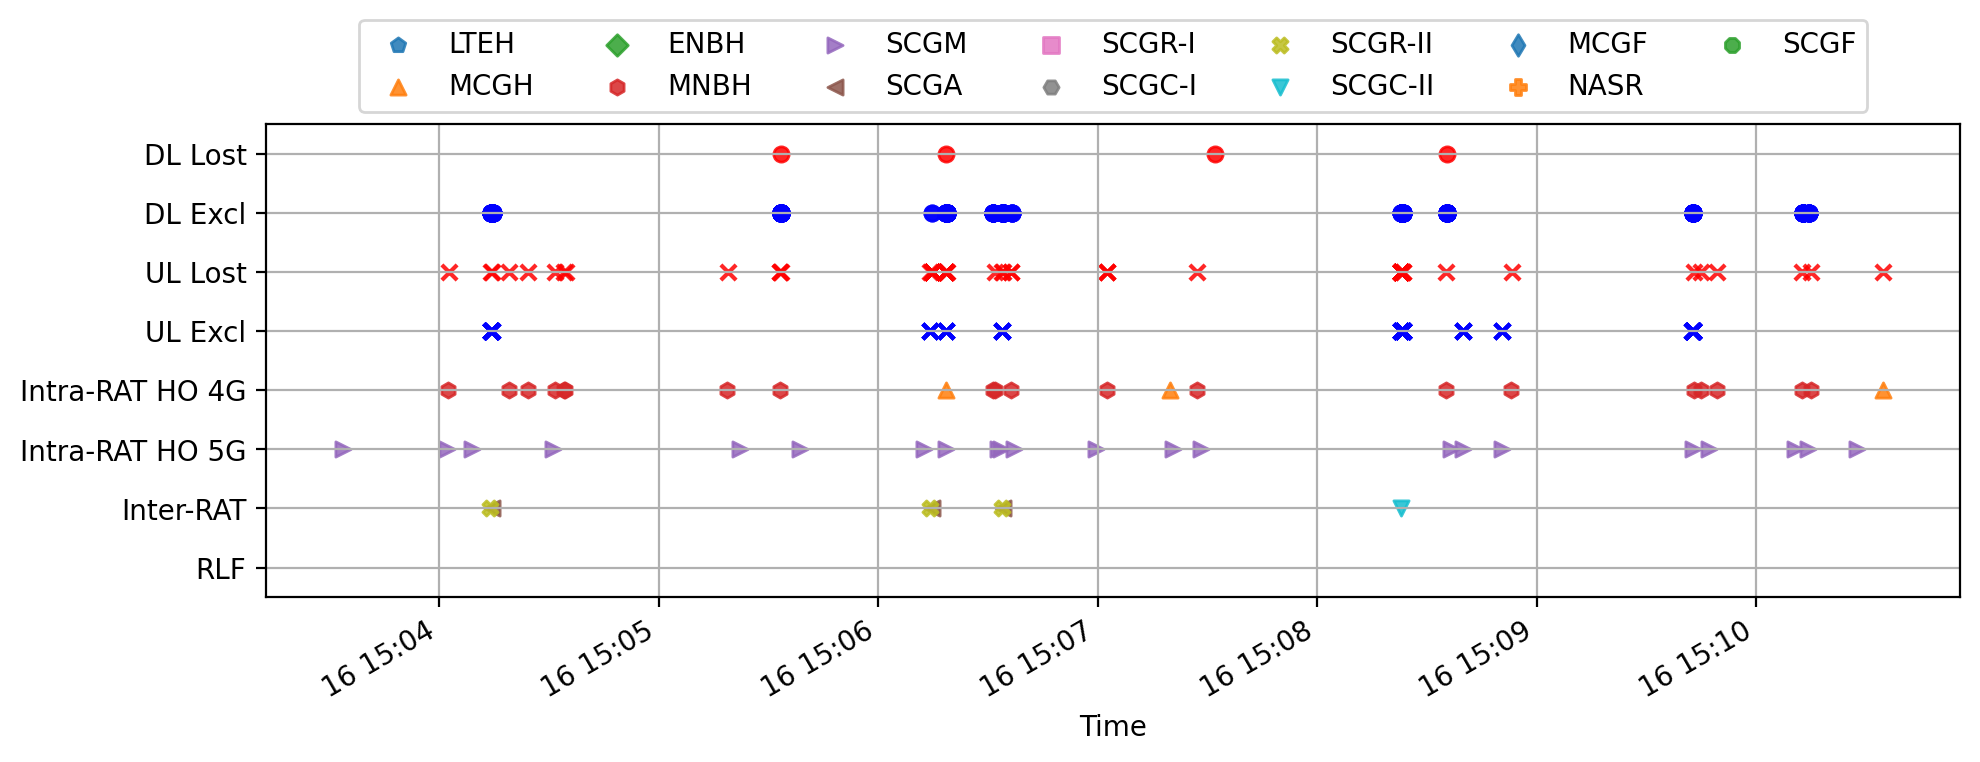

In [190]:
single_radio_visualize(dl_df.copy(), ul_df.copy(), ho_df.copy())
# single_radio_visualize(dl_df.copy(), ul_df.copy(), ho_df.copy(), start_time='15:05', stop_time='15:06')

## Dual Radio Trace Visualize

In [93]:
date1 = '2023-11-09'; name1 = 'UDP_Bandlock_9S_Phone_Brown'; dev1 = 'sm00'; trip1 = '#01'
date2 = '2023-11-09'; name2 = 'UDP_Bandlock_9S_Phone_Brown'; dev2 = 'sm01'; trip2 = '#01'
data_dir1 = os.path.join(root_dir, date1, name1, dev1, trip1, 'data')
data_dir2 = os.path.join(root_dir, date2, name2, dev2, trip2, 'data')
# print(os.path.isdir(data_dir1))
# print(os.path.isdir(data_dir2))

rrc_filepaths = tuple([[os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('rrc.csv')][0] for data_dir in [data_dir1, data_dir2]])
lte_filepaths = tuple([[os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and not s.endswith('nr_ml1.csv') and s.endswith('ml1.csv')][0] for data_dir in [data_dir1, data_dir2]])
nr_filepaths = tuple([[os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.startswith('diag_log') and s.endswith('nr_ml1.csv')][0] for data_dir in [data_dir1, data_dir2]])
dl_filepaths = tuple([os.path.join(data_dir, 'udp_dnlk_loss_latency.csv') for data_dir in [data_dir1, data_dir2]])
ul_filepaths = tuple([os.path.join(data_dir, 'udp_uplk_loss_latency.csv') for data_dir in [data_dir1, data_dir2]])

print(rrc_filepaths[0], os.path.isfile(rrc_filepaths[0]))
print(rrc_filepaths[1], os.path.isfile(rrc_filepaths[1]))
print(lte_filepaths[0], os.path.isfile(lte_filepaths[0]))
print(lte_filepaths[1], os.path.isfile(lte_filepaths[1]))
print(nr_filepaths[0], os.path.isfile(nr_filepaths[0]))
print(nr_filepaths[1], os.path.isfile(nr_filepaths[1]))
print(dl_filepaths[0], os.path.isfile(dl_filepaths[0]))
print(dl_filepaths[1], os.path.isfile(dl_filepaths[1]))
print(ul_filepaths[0], os.path.isfile(ul_filepaths[0]))
print(ul_filepaths[1], os.path.isfile(ul_filepaths[1]))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-11-09_12-20-44_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/diag_log_sm01_2023-11-09_12-20-44_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-11-09_12-20-44_ml1.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/diag_log_sm01_2023-11-09_12-20-44_ml1.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-11-09_12-20-44_nr_ml1.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/diag_log_sm01_2023-11-09_12-20-44_nr_ml1.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedfo